In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

(Running UniTVelo 0.2.5.2)
2024-07-24 14:03:35


In [75]:
save_dir = '0722_183642'
data_set = 'E18_mouse_brain_10X/Mode_1'
path_result = '/data/nelkazwi/RNA_velo/Unitvelo_atac/'+data_set+'/'#/checkpoints/VelocityDemo/'
adata = sc.read(path_result+str(save_dir)+"/model_last.h5ad")
adata_atac = sc.read(path_result+str(save_dir)+"/model_last_atac.h5ad")

In [94]:
c_ = np.where(np.log(adata.varm["fit_region_weights"])!=0)[1]
r_ = np.where(np.log(adata.varm["fit_region_weights"])!=0)[0]

In [99]:
alpha_unit = np.zeros([adata.shape[0], adata.shape[1]])
u_dots = np.zeros([adata.shape[0], adata.shape[1]])
gene_names = adata.var_names#[adata.var['velocity_genes']]
for i, gene_name in enumerate(gene_names):
    n = np.where(adata.var_names==gene_name)[0][0]
    
    s = np.power(adata.obs["latent_time"]-adata.var["fit_t"][n],2)
    s = np.exp(-1*adata.var["fit_a"][n]*s)
    s = adata.var["fit_h"][n]*s+adata.var["fit_offset"][n]

    s_dot = s*(adata.obs["latent_time"]-adata.var["fit_t"][n])*(-2*adata.var["fit_a"][n])

    u = s_dot+adata.var["fit_gamma"][n]*s
    u = u/adata.var["fit_beta"][n]
    u = u + adata.var["fit_intercept"][n]

    u_dot = (adata.obs["latent_time"]-adata.var["fit_t"][n])*(-2*adata.var["fit_a"][n])
    u_dot = u_dot+adata.var["fit_gamma"][n]
    u_dot = u_dot*s_dot
    u_dot = u_dot-2*adata.var["fit_a"][n]*s
    u_dot = u_dot/np.power(adata.var["fit_beta"][n],2)
    u_dots[:,i] = u_dot
    alpha = u_dot + adata.var["fit_beta"][n]*u
    #adata.obs["alpha_{}".format(gene_name)] = alpha
    alpha_unit[:,i] = alpha

In [100]:
Mu = adata.layers["unspliced"]
alpha_atac = np.zeros([adata.shape[0], adata.shape[1]])
u_dot_atac = np.zeros([adata.shape[0], adata.shape[1]])
gene_names = adata.var_names
counter = 0
for i, gene_name in enumerate(gene_names):
    gene_number = np.where(adata.var_names == gene_name)[0][0]
    r_g = adata.varm["fit_region_weights"][gene_number, c[r == gene_number]]
    if r_g.shape[0] == 0:
        counter += 1
    phi_r = adata_atac.obsm["cisTopic"][:, c[r == gene_number]]
    w_r = np.multiply(phi_r,r_g).sum(axis=1)
    etta = adata.var['fit_etta'][gene_number]
    alpha_atac[:,i] = etta * w_r
    (u_dot_atac[:,i])[:,np.newaxis] = ( alpha_atac[:,i] )[:,np.newaxis] - adata.var["fit_beta"][i] * Mu[:,i]

    

In [101]:
alpha_atac_ = alpha_atac[:,alpha_atac.sum(axis=0) != 0]
alpha_unit_ = alpha_unit[:,alpha_atac.sum(axis=0) != 0]

In [118]:
r2_scores = np.zeros(alpha_atac_.shape[1])
for i in np.arange(0, alpha_atac_.shape[1]):
 r2_scores[i] = r2_score(alpha_atac_[:,i],alpha_unit_[:,i])

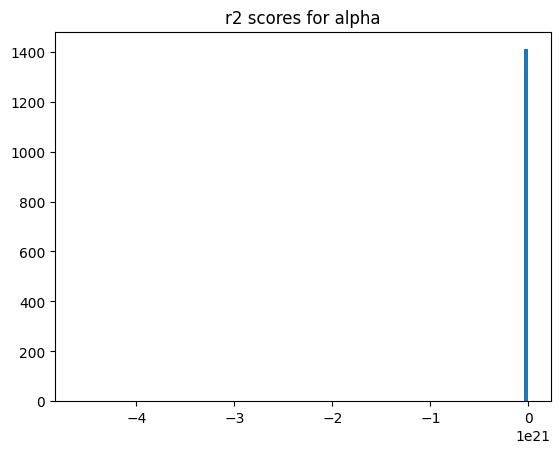

In [119]:
plt.hist(r2_scores,bins = 100)
plt.title('r2 scores for alpha')
plt.show()


In [20]:
u_dots = adata.layers['u_derrivative']
u_dot_atac = adata.layers['u_atac']
wr = adata.varm["fit_region_weights"]
gene_names = adata.var_names

In [21]:
u_dots =u_dots[:,adata.var["velocity_genes"]]
u_dot_atac = u_dot_atac[:,adata.var["velocity_genes"]]
wr = wr[adata.var["velocity_genes"],:]
gene_names = gene_names[adata.var["velocity_genes"]]

In [22]:
u_dots_ = u_dots[:,u_dot_atac.sum(axis=0) != 0]
u_dot_atac_ = u_dot_atac[:,u_dot_atac.sum(axis=0) != 0]
wr = wr[u_dot_atac.sum(axis=0) != 0,:]
gene_names = gene_names[u_dot_atac.sum(axis=0) != 0]

In [23]:
c = np.where(np.log(wr)!=0)[1]
r = np.where(np.log(wr)!=0)[0]

In [24]:
r2_scores = np.zeros(u_dot_atac_.shape[1])
for i in np.arange(0, u_dot_atac_.shape[1]):
 r2_scores[i] = r2_score(u_dot_atac_[:,i],u_dots_[:,i])

In [57]:
threshold = 0.3
x = np.where(r2_scores>threshold)[0]

In [69]:
r2_scores_ = r2_scores[x]

In [70]:
gene_list = []
for i, g in enumerate(x):
 print(g, gene_names[g], wr[g,c[r == g]].shape[0], wr[g,c[r == g]], r2_scores_[i])
 gene_list.append(gene_names[g])


23 Epha4 1 [0.1742599] 0.46561562719393246
35 Gli2 1 [0.2640082] 0.3767819499793863
37 Dbi 2 [0.7274518  0.06453861] 0.31860828978082867
38 Tmem163 4 [0.40614036 0.149769   0.23156056 0.2670334 ] 0.3587155718977667
39 Mcm6 1 [0.14079422] 0.40530093490748254
55 Prrx1 1 [0.16841345] 0.3509537712978982
57 Pou2f1 1 [0.09038211] 0.7369364434330861
65 Lbr 1 [0.15863807] 0.341310395014611
79 Paqr8 3 [0.2944793  0.13131812 0.14095618] 0.46283295873605335
85 Nbeal1 1 [0.15669295] 0.3877867312505703
88 Creb1 1 [0.15245087] 0.45302115554060196
100 Ccnt2 2 [0.24560018 0.22549807] 0.3205627747160421
105 Dennd1b 1 [0.45533952] 0.30257604426797013
114 Igsf8 2 [0.1613887  0.23386249] 0.5296541694064609
122 Slc30a10 1 [0.23319814] 0.36722410764710967
126 Tab2 2 [0.04088225 0.24631825] 0.3886519038927465
142 Reep3 2 [0.20092893 0.03946935] 0.30482863054879916
151 Nedd1 1 [0.16599849] 0.4252001620542729
167 Plagl1 2 [0.22412649 0.18209027] 0.3722253703624685
168 Hivep2 2 [0.33729944 0.24918362] 0.3953964

In [ ]:
gene_name = "Reep3"
adata.var[adata.var_names == gene_name]#['velocity_genes']
gene_number = np.where(adata.var_names == gene_name)[0][0]
r_g = adata.varm["fit_region_weights"][gene_number,c_[r_ == gene_number]]
adata_atac.var["chromStart"][c_[r_ == gene_number]]

In [46]:
distance_regions = adata_atac.var["chromStart"][c_[r_ == gene_number]].values
gene_end = adata.var[adata.var_names == gene_name]["chromEnd"].values[0]
gene_start = adata.var[adata.var_names == gene_name]["chromStart"].values[0]
plt.axvline(x=0, ymin=0, ymax=10,color='green', linestyle='dotted')
plt.axvline(x=gene_end - gene_start, ymin=0, ymax=10,color='red', linestyle='dotted')
plt.xlim([-10000,20000])
sns.scatterplot(x= distance_regions - gene_start, y=r_g )

In [64]:
# enr_KEGG = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
#                  gene_sets=['KEGG_2021_Human'],#
#                  organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
#                  outdir=None,
                 
#                 )

enr_GO = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['GO_Biological_Process_2023'],#
                 organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                  cutoff=1
                )

enr_WP = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['WikiPathways_2019_Mouse'],#
                 organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.05
                )


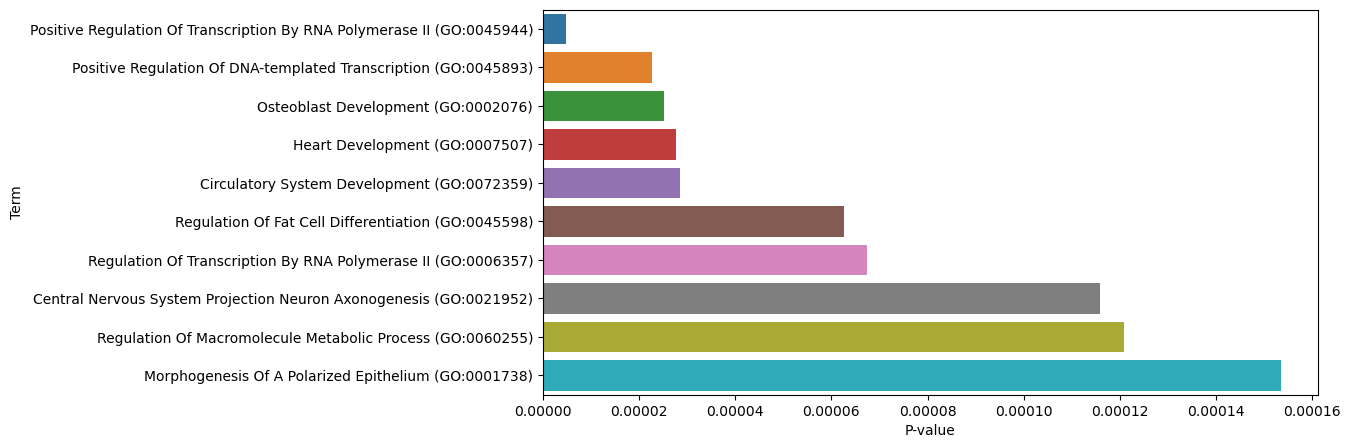

In [66]:
plt.figure(figsize = (10,5))
ax = sns.barplot(data = enr_GO.results.iloc[0:10,:], x = 'P-value', y = 'Term')
plt.show()

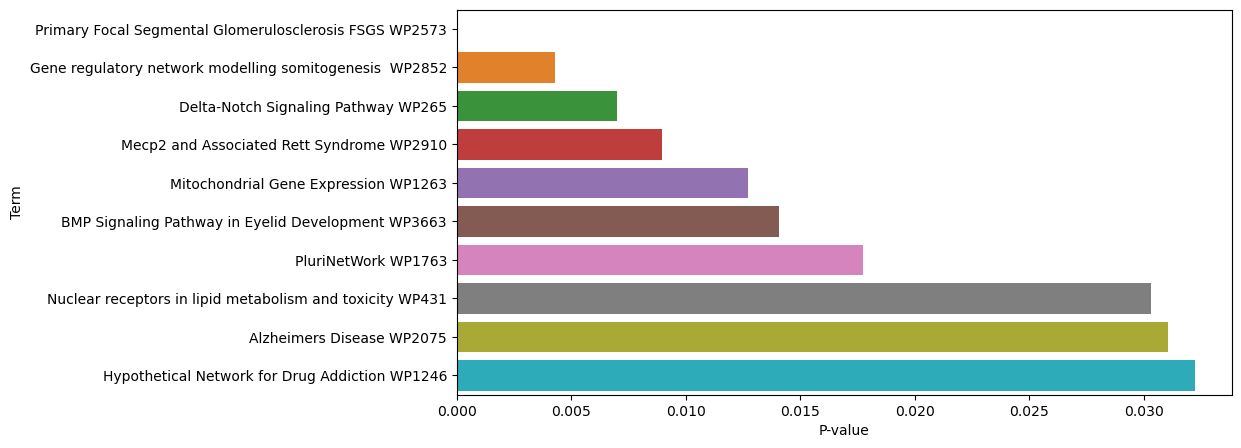

In [67]:
plt.figure(figsize = (10,5))
ax = sns.barplot(data = enr_WP.results.iloc[0:10,:], x = 'P-value', y = 'Term')
plt.show()

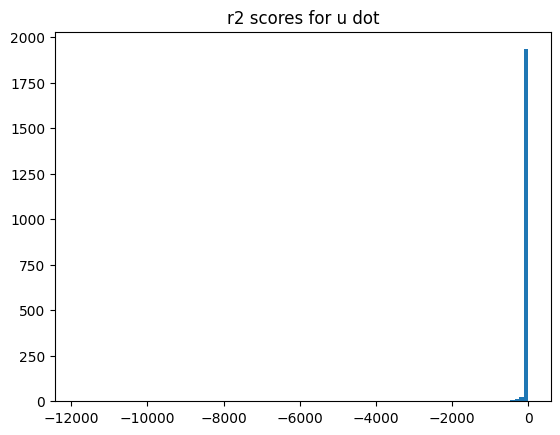

In [12]:
plt.hist(r2_scores,bins = 100)
plt.title('r2 scores for u dot')
plt.show()


In [13]:
r2_scores

array([-8.93868798e+00, -1.81874520e+02, -1.69093401e-01, ...,
       -2.25240793e+00, -2.84357220e-03, -2.77723462e+00])

In [14]:
r2_score(u_dot_atac_[:,i],u_dots_[:,i])

-2.777234622502248

In [129]:
adata.varm["fit_region_weights"][10, c[r == 10]]


array([97.31163 , 17.142277], dtype=float32)